<a href="https://colab.research.google.com/github/Shada97/Weather-Forecasting-using-ARIMA/blob/main/WeatherForecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


<br> **Project Topic: Weather Forecasting Using Time Series Data**
<br>
<br> **Project Team**
<br>Shaghayegh Arabi       - 400551598
<br> Sung Lai Horace Wong   - 400547251
<br> Wu Yeuk Sze Joyce      - 400545971

---------------------------------------------------------------------------------------------------------------------------------
**Things to Note**
<br>
<br>
1 . Please ensure that Appendix C "Cleaned Data Week.csv" is placed at the same folder directory as this Jupyter file. Otherwise, the program might have issues identifying the target directory for importing the data
<br>
2. All of the codes in this Jupyter file has to be executed sequentially from top to bottom

---------------------------------------------------------------------------------------------------------------------------------
**Appendix A - Project Codes**

**01 - Preparation**

In [ ]:
# 01 - Preparation: Import the necessary library
import pandas as pd
import numpy as np
import pmdarima as pm
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import seaborn as sns
from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy.stats import jarque_bera  # Import from scipy
import statsmodels.tsa.api as tsa
from scipy.stats import median_abs_deviation
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import probplot  # Import probplot explicitly



**02 - Data Import and Organization**

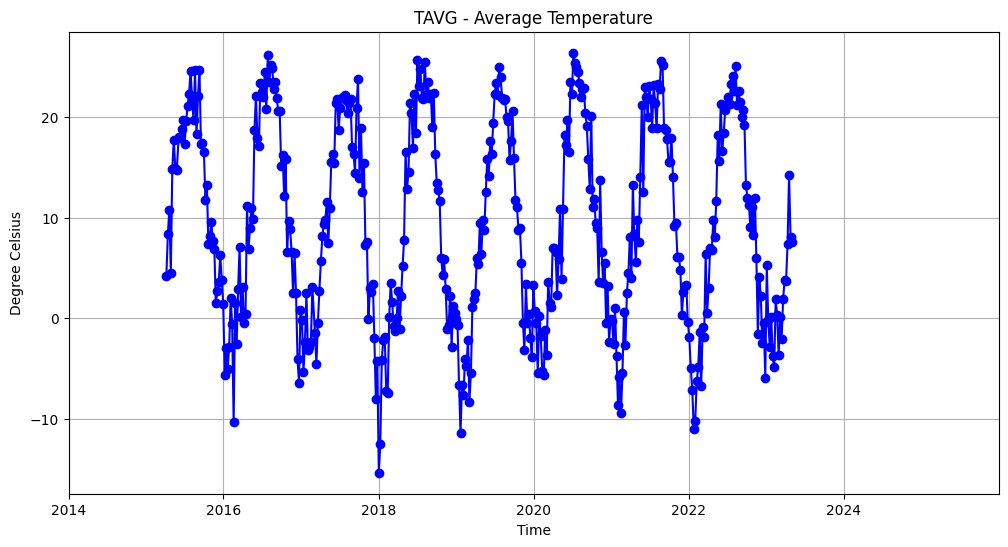

count    421.000000
mean       9.467798
std       10.046790
min      -15.367000
25%        0.717000
50%        8.900000
75%       18.967000
max       26.417000
dtype: float64


In [ ]:
# 02 - Data Import
# 02-1 - Load the CSV file into a DataFrame
file_path = 'Cleaned Data Week.csv'  # Replace with your file path
data = pd.read_csv(file_path)

# 02-2 - Getting Average Temperature from 1 April 2014 to 31 March 2024
data_range = 471            # Based on the csv file, there are a total of 471 data samples
testing_range = 50          # Reserve the last 50 datapoint for testig the prediction model

TAVG_tsx = data['Average Temp - Weekly'][0 : data_range - testing_range]
TAVG_tsx_test = data['Average Temp - Weekly'][data_range - testing_range : data_range]

# Drop NaN values from TAVG
TAVG_tsx = TAVG_tsx.dropna()

# 02-3 - Convert to pandas Series with a DateTime index
# Assuming 'Date at the start of week' is the date column in your CSV
data['Date at the start of week'] = pd.to_datetime(data['Date at the start of week'], dayfirst=True)

# 02-4 - Splitting the dataset into training and testing data
# 50 data samples towards the end of the time series are set aside as the testing data
TAVG = pd.Series(TAVG_tsx.values, index=data['Date at the start of week'][0 : data_range - testing_range])
TAVG_test = pd.Series(TAVG_tsx_test.values, index=data['Date at the start of week'][data_range - testing_range : data_range])


# 02-5 - Plotting the time series
plt.figure(figsize=(12, 6))
plt.plot(TAVG, 'o-', color='blue')
plt.title('TAVG - Average Temperature')
plt.xlabel('Time')
plt.ylabel('Degree Celsius')
plt.xlim(pd.Timestamp('2014-01-01'), pd.Timestamp('2025-12-31'))
plt.grid(True)
plt.show()

# 02-6 - Summary of the time series
summary = TAVG.describe()
print(summary)


There might be a seasonal pattern in the time series plot.

**03 - Data Exploration**

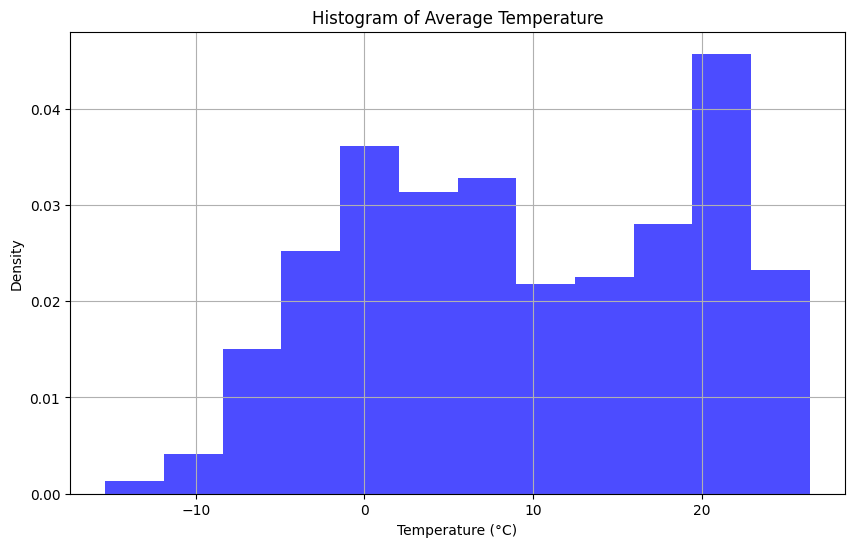

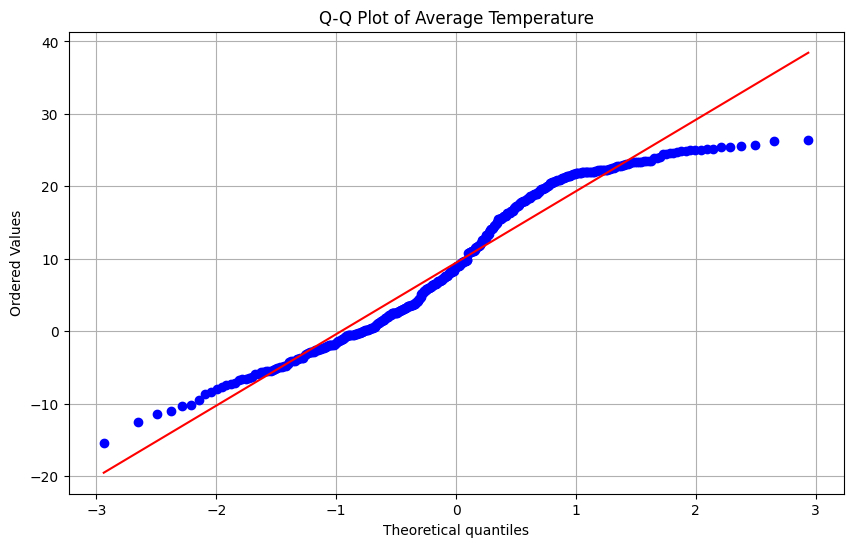

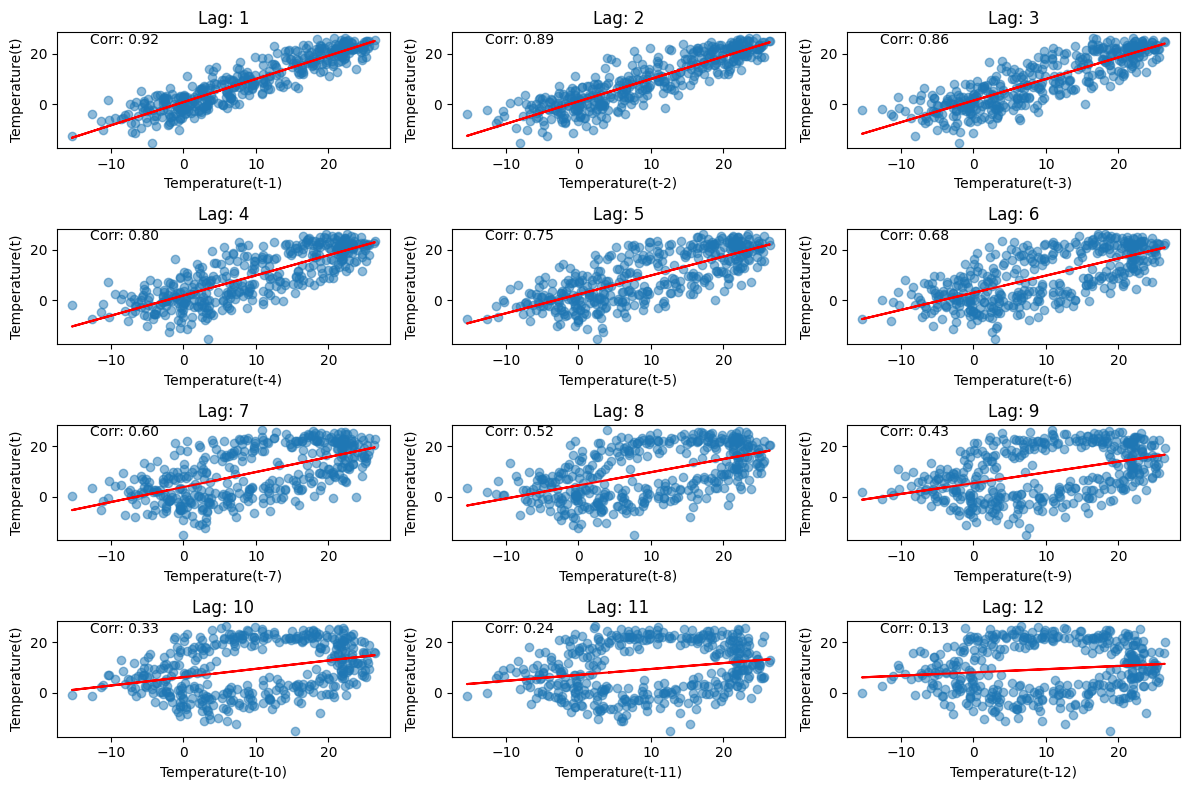

In [ ]:
# 03 - Data Exploration
# 03-1 - Create the histogram of the time series data
plt.figure(figsize=(10, 6))
plt.hist(TAVG, bins=12, density=True, color='blue', alpha=0.7)
plt.title('Histogram of Average Temperature')
plt.xlabel('Temperature (°C)')
plt.ylabel('Density')
plt.grid(True)
plt.show()

# 03-2 - Create the Q-Q plot for checking normality of the dataset
plt.figure(figsize=(10, 6))
stats.probplot(TAVG, dist="norm", plot=plt)
plt.title('Q-Q Plot of Average Temperature')
plt.grid(True)
plt.show()

# 03-3 - Create lag plots to determine the correlations between data samples
def lag_plot(data, max_lag=1, corr=True, smooth=False):
    plt.figure(figsize=(12, 8))
    num_plots = max_lag
    rows = int(np.ceil(np.sqrt(num_plots)))
    cols = int(np.ceil(num_plots / rows))

    for h in range(1, max_lag + 1):
        plt.subplot(rows, cols, h)
        lagged = data.shift(h).dropna()  # Drop NaN values from lagged data
        data_lagged = data[h:].dropna()  # Corresponding data points

        # Ensure there are enough data points for fitting
        if len(lagged) > 1 and len(data_lagged) > 1:
            plt.scatter(lagged, data_lagged, alpha=0.5)
            plt.title(f'Lag: {h}')
            plt.xlabel(f'Temperature(t-{h})')
            plt.ylabel('Temperature(t)')

            if smooth:
                try:
                    z = np.polyfit(lagged, data_lagged, 1)
                    p = np.poly1d(z)
                    plt.plot(lagged, p(lagged), color='red')
                except np.linalg.LinAlgError:
                    print(f"Linear fit failed for lag {h}")

            if corr:
                correlation = np.corrcoef(lagged, data_lagged)[0, 1]
                plt.annotate(f'Corr: {correlation:.2f}', xy=(0.1, 0.9), xycoords='axes fraction', fontsize=10)

        else:
            plt.scatter([], [], alpha=0)  # Empty scatter for plots without data
            plt.title(f'Lag: {h} (Not enough data)')
            plt.xlabel(f'Temperature(t-{h})')
            plt.ylabel('Temperature(t)')

    plt.tight_layout()
    plt.show()

# 03-4 - Call the lag plot function
lag_plot(TAVG, max_lag=12, corr=True, smooth=True)


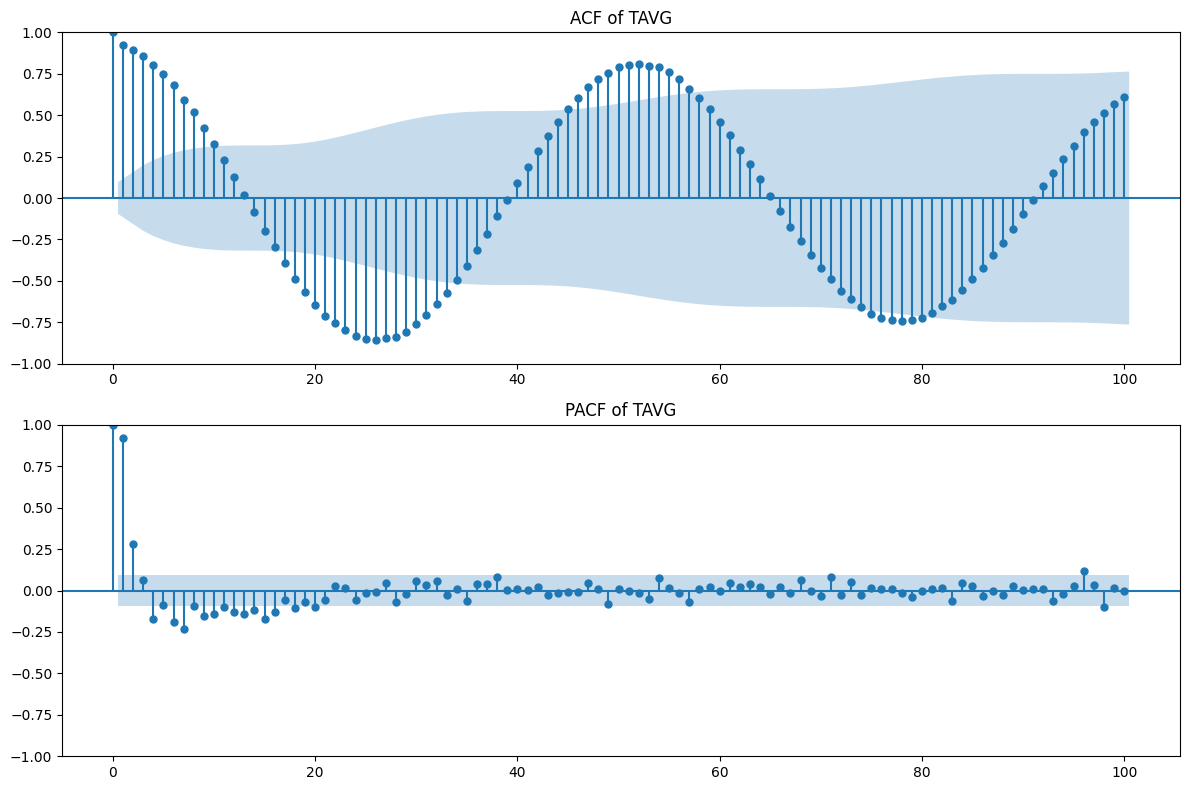

In [ ]:
# 03-4 - Create ACF and PACF plots for original series to determine the stationarity of dataset
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plot_acf(TAVG, lags=100, ax=plt.gca(), title="ACF of TAVG")
plt.subplot(2, 1, 2)
plot_pacf(TAVG, lags=100, ax=plt.gca(), title="PACF of TAVG")
plt.tight_layout()
plt.show()

**04 - Data Preprocessing**
<br>
<br>
**04-A - 1st Order Differencing**

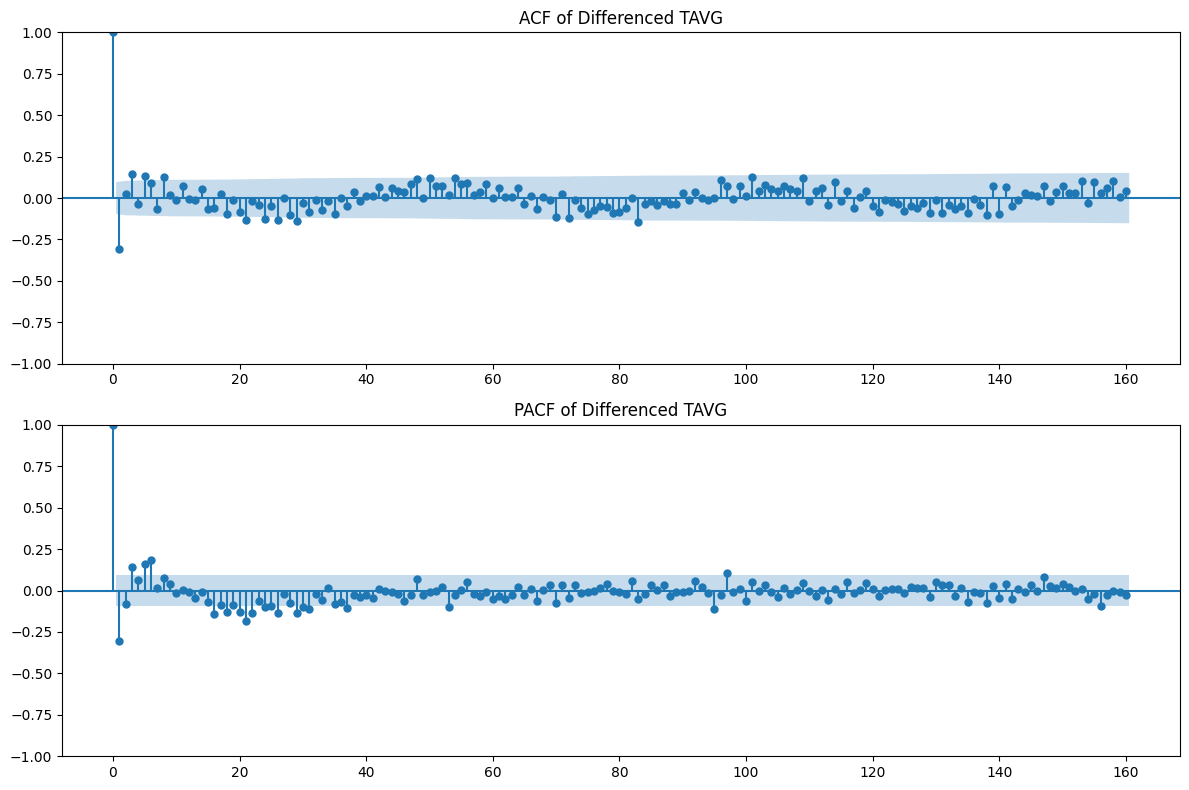

In [ ]:
# 04-1 - Differencing - 1st order differencing of the original series
diff_TAVG = TAVG.diff().dropna()

# 04-2 - Create ACF and PACF plots for the differenced series
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plot_acf(diff_TAVG, lags=160, ax=plt.gca(), title="ACF of Differenced TAVG") # non-stationary, seasonal period=52
plt.subplot(2, 1, 2)
plot_pacf(diff_TAVG, lags=160, ax=plt.gca(), title="PACF of Differenced TAVG")
plt.tight_layout()
plt.show()

**04-B - Seasonal Differencing**

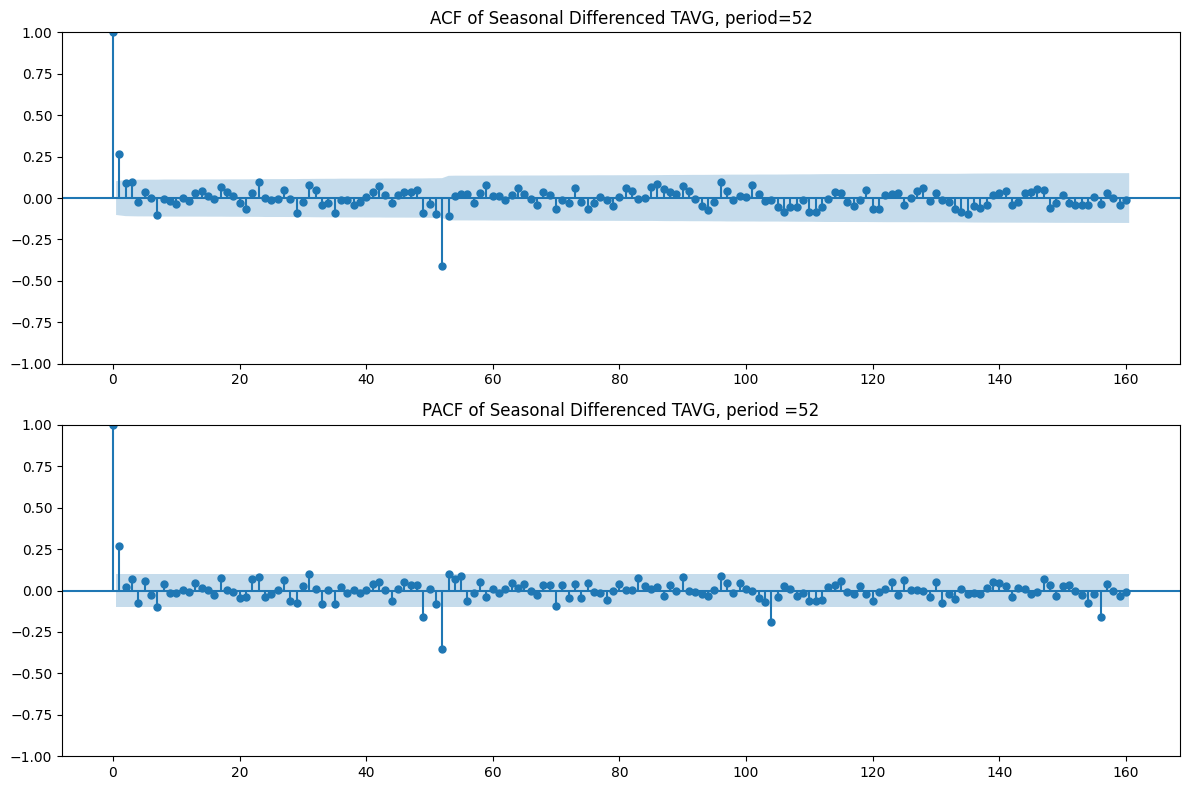

In [ ]:
# 04-3 - Differencing - Seasonal differencing (without including the 1st order differencing)
sdTAVG = TAVG.diff(periods=52).dropna()



# 04-4 - Create ACF and PACF plots for the seasonal differenced series
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plot_acf(sdTAVG, lags=160, ax=plt.gca(), title="ACF of Seasonal Differenced TAVG, period=52")
plt.subplot(2, 1, 2)
plot_pacf(sdTAVG, lags=160, ax=plt.gca(), title="PACF of Seasonal Differenced TAVG, period =52")
plt.tight_layout()
plt.show()
# PACF tails off, ACF cuts off after lag 1 , MA(1)

**04-C - 1st Order Differencing + Seasonal Differencing**

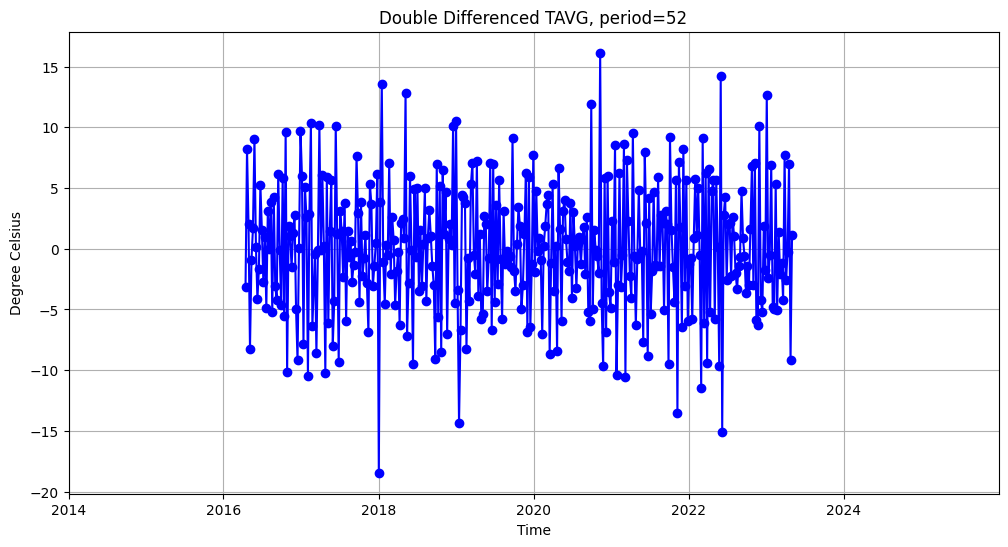

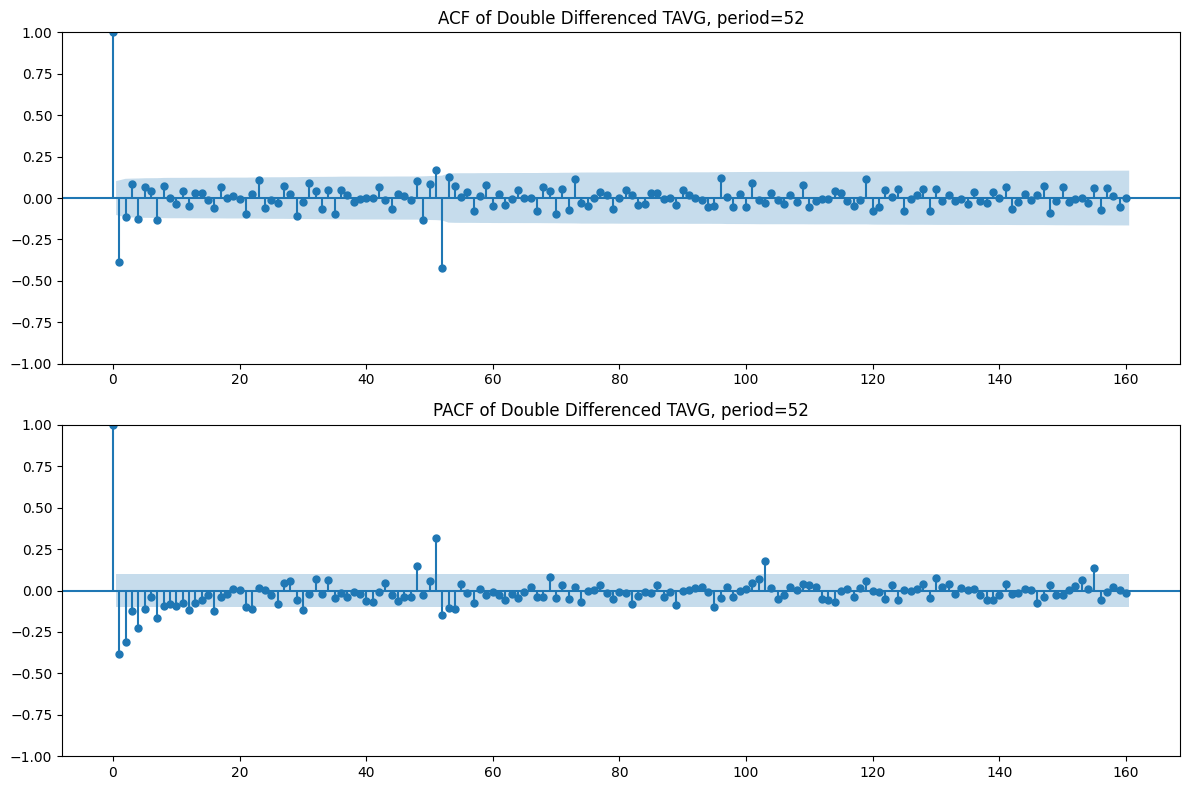

In [ ]:
# 04-5 - Differencing - 1st Order Differencing + Seasonal Differencing
fdTAVG = diff_TAVG.diff(periods=52).dropna()

# 04-6 - Plotting variance
plt.figure(figsize=(12, 6))
plt.plot(fdTAVG, 'o-', color='blue')
plt.title('Double Differenced TAVG, period=52')
plt.xlabel('Time')
plt.ylabel('Degree Celsius')
plt.xlim(pd.Timestamp('2014-01-01'), pd.Timestamp('2025-12-31'))
plt.grid(True)
plt.show()

# 04-7 - Create ACF and PACF plots for the differenced data
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plot_acf(fdTAVG, lags=160, ax=plt.gca(), title="ACF of Double Differenced TAVG, period=52")
plt.subplot(2, 1, 2)
plot_pacf(fdTAVG, lags=160, ax=plt.gca(), title="PACF of Double Differenced TAVG, period=52")
plt.tight_layout()
plt.show()

Now we know that the seasonal model order is MA(1) with period = 52. Then we try to fit in the model for original model by starting from MARIMA(0,1,0).

**05 - Manual ARIMA - Development of Initial ARIMA Model**

In [ ]:
# 05-1 - Create an initial ARIMA model (0,1,0) with seasonal (0,1,1) and period=52
model = ARIMA(TAVG, order=(0, 1, 0), seasonal_order=(0, 1, 1, 52))
fit1 = model.fit()

# 05-2 - Parameter estimates
print(fit1.params)

c:\Users\horac\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\horac\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\horac\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ma.S.L52    -0.926952
sigma2      15.576415
dtype: float64


[0.21241339 2.96926726]
Noise Variance: 19.879506060104628


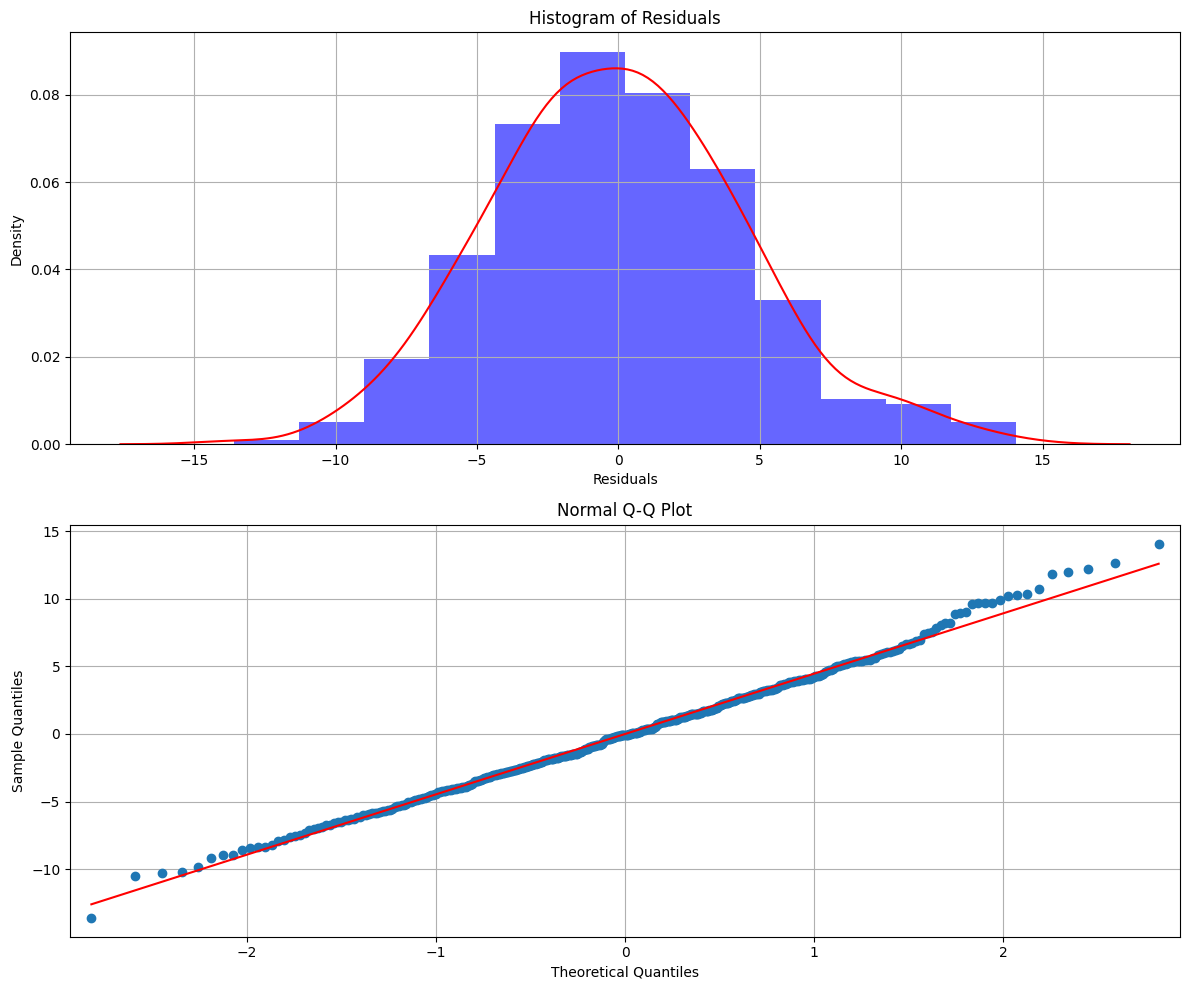

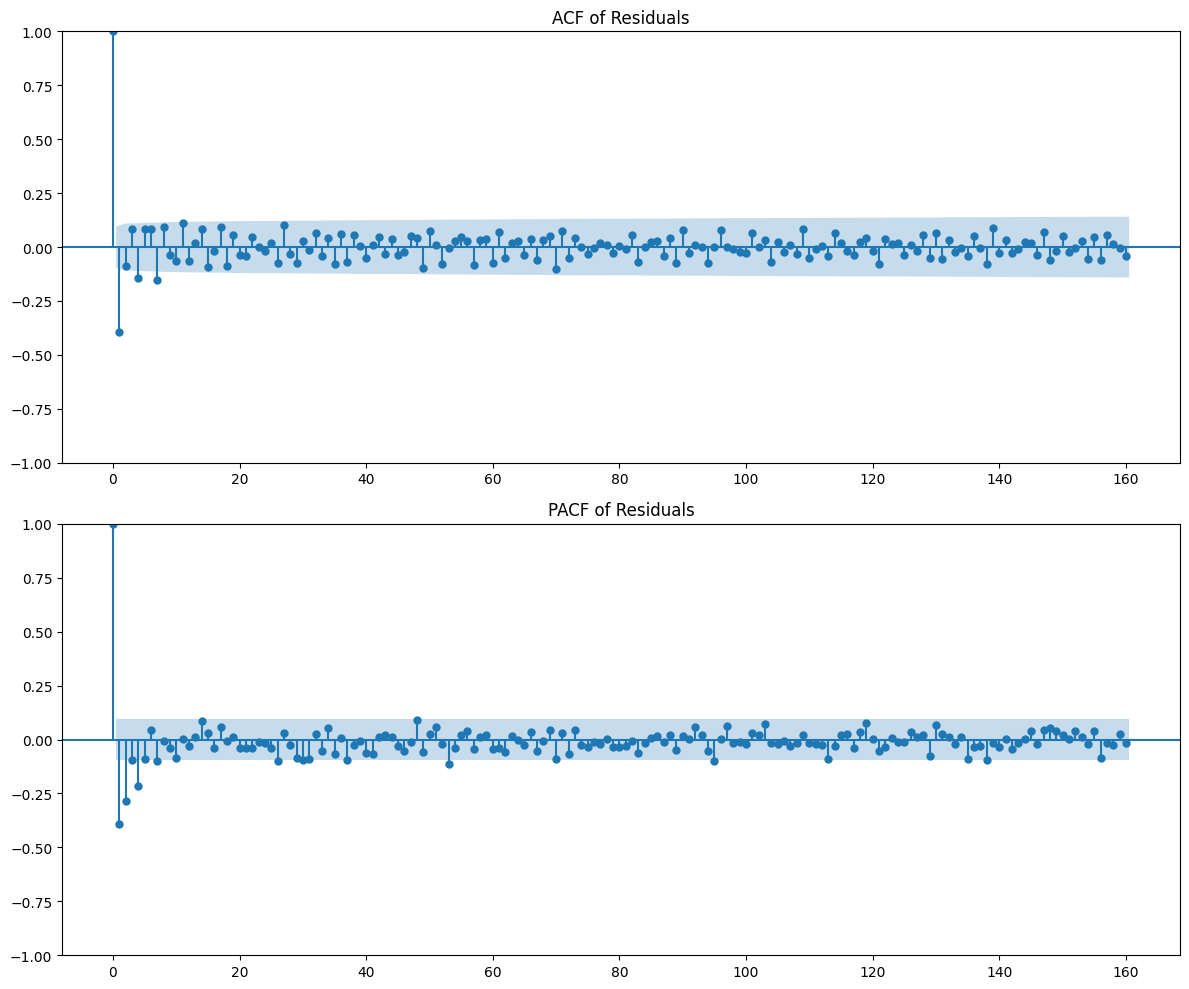

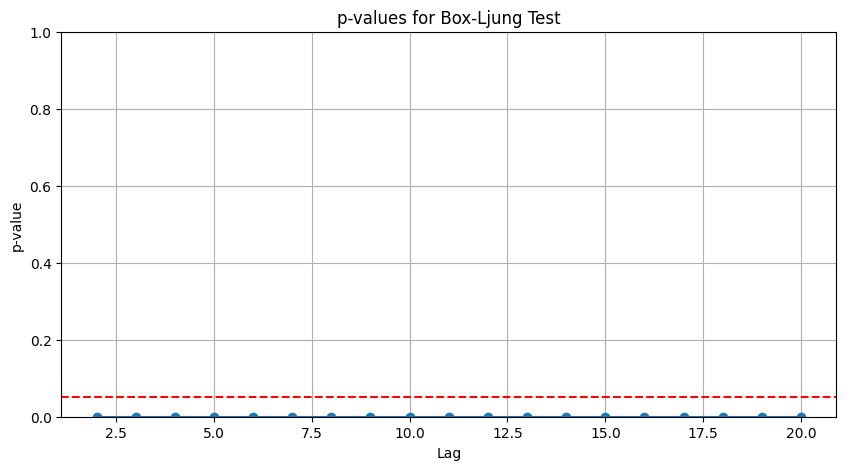

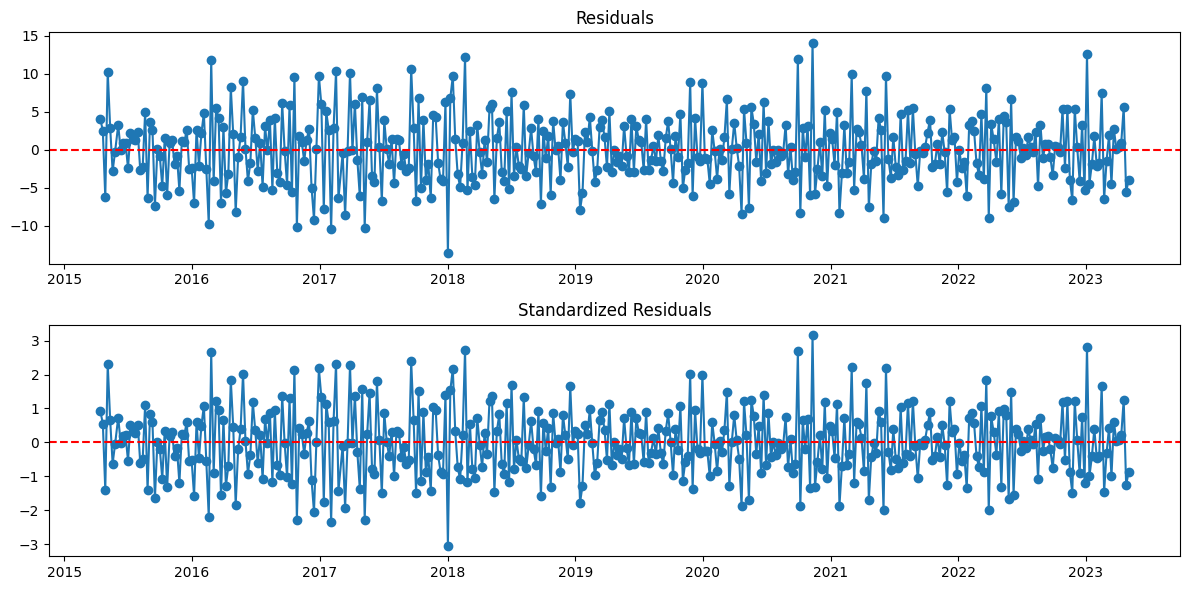

Jarque-Bera Statistic: 3.466321164205277, p-value: 0.17672497257625502


In [ ]:
# 05-3 - Standard errors
print(np.sqrt(np.diag(fit1.cov_params())))

# 05-4 - Noise variance (calculate from residuals)
res1 = fit1.resid[1:]
noise_variance = np.var(res1)
print(f'Noise Variance: {noise_variance}')

# Set up graphics
plt.figure(figsize=(12, 10))

# 05-5 - Histogram of residuals
plt.subplot(2, 1, 1)
plt.hist(res1, bins=12, density=True, alpha=0.6, color='b')
sns.kdeplot(res1, color='red')  # Kernel density estimate
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.grid()

# 05-6 - Q-Q plot
plt.subplot(2, 1, 2)
sm.qqplot(res1, line='s', ax=plt.gca())
plt.title('Normal Q-Q Plot')
plt.grid()

plt.tight_layout()
plt.show()

# 05-7 - ACF and PACF plots for residuals
plt.figure(figsize=(12, 10))
plt.subplot(2, 1, 1)
sm.graphics.tsa.plot_acf(res1, lags=160, ax=plt.gca(), title='ACF of Residuals')
plt.subplot(2, 1, 2)
sm.graphics.tsa.plot_pacf(res1, lags=160, ax=plt.gca(), title='PACF of Residuals')
plt.tight_layout()
plt.show()

# 05-8 - Box-Ljung test
p_values = []

for lag in range(2, 21):
    try:
        lb_test = acorr_ljungbox(res1, lags=[lag], return_df=True)
        p_values.append(lb_test.iloc[0]['lb_pvalue'])  # Extract p-value


    except Exception as e:
        print(f'Error for lag {lag}: {e}')
        p_values.append(None)  # Append None for errors

# 05-9 - Plot p-values for Box-Ljung test
plt.figure(figsize=(10, 5))
plt.plot(range(2, 21), p_values, marker='o')
plt.axhline(y=0.05, color='r', linestyle='--')
plt.title('p-values for Box-Ljung Test')
plt.xlabel('Lag')
plt.ylabel('p-value')
plt.ylim(0, 1)
plt.grid()
plt.show()

# 05-10 - Plot residuals and standardized residuals
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(res1, marker='o')
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuals')

# 05-11 - Standardized residuals calculation
std_residuals = res1 / np.std(res1)

plt.subplot(2, 1, 2)
plt.plot(std_residuals, marker='o')
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Standardized Residuals')
plt.tight_layout()
plt.show()

# 05-12 - Jarque-Bera test for normality
jb_stat, jb_p = jarque_bera(res1)
print(f'Jarque-Bera Statistic: {jb_stat}, p-value: {jb_p}')

**Analysis on residuals from the initial model**
<br>
From the above analysis on the residuals generating from the initial ARIMA model, the ACF plot cuts off after lag 1, while the PACF plot tails off in the negative value. It indicates the requirement to adjust MA parameter of the non-seasonal component of the model to 1 (i.e. q = 1)

**06 - Manual ARIMA - Adjustment of Model Parameters**
<br>
<br>
**06-A - 1st Adjustment**

In [ ]:
# 06-A-1 - Fit ARIMA model (0,1,1) with seasonal (0,1,1) and period=52
model = ARIMA(TAVG, order=(0, 1, 1), seasonal_order=(0, 1, 1, 52))
fit2 = model.fit()

# 06-A-2 - Parameter estimates
print(fit2.params)

c:\Users\horac\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\horac\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\horac\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ma.L1      -0.951444
ma.S.L52   -0.998875
sigma2      9.684319
dtype: float64


[1.64123752e-02 1.58883063e+01 1.53542726e+02]
Noise Variance: 14.218315218494292


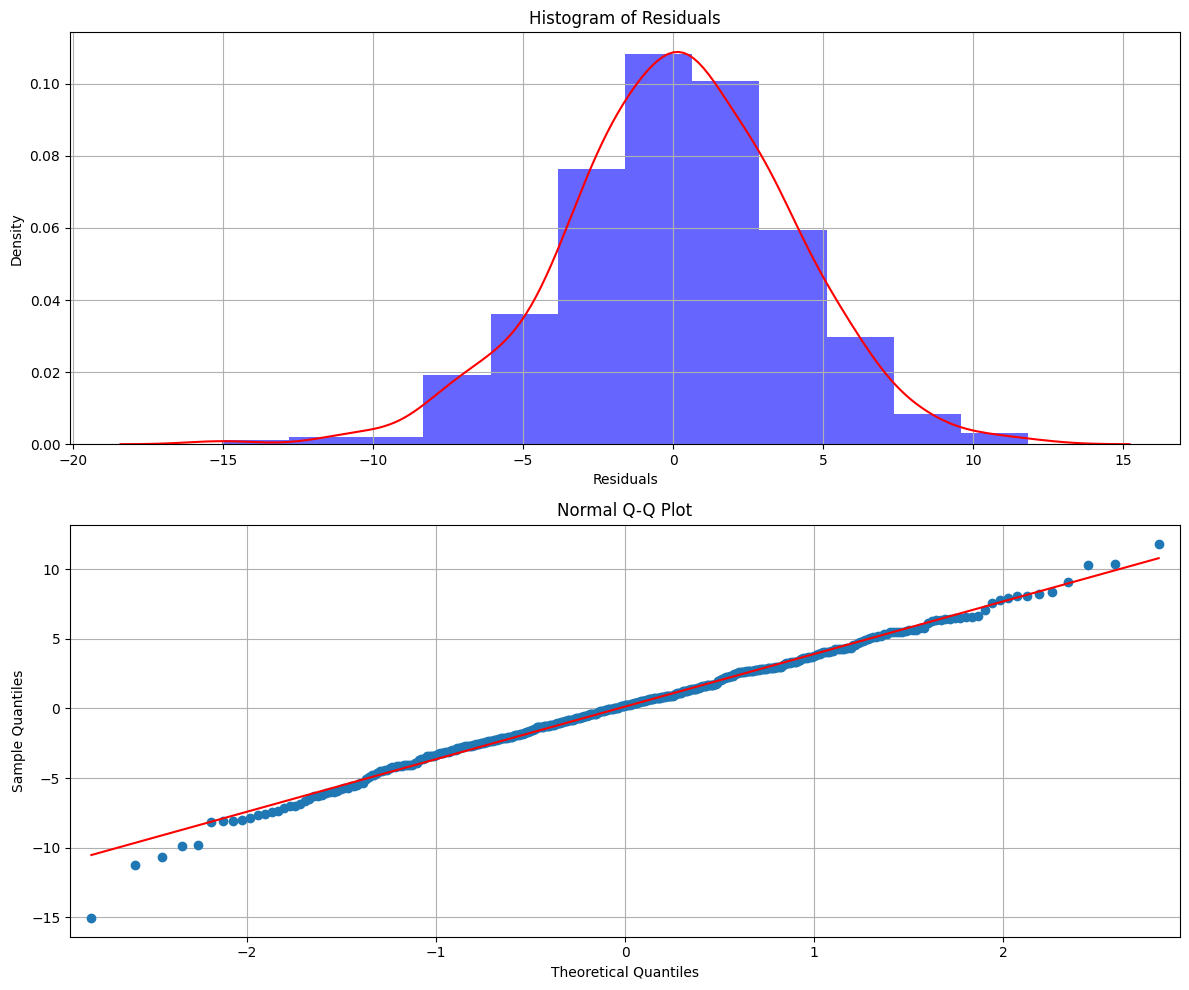

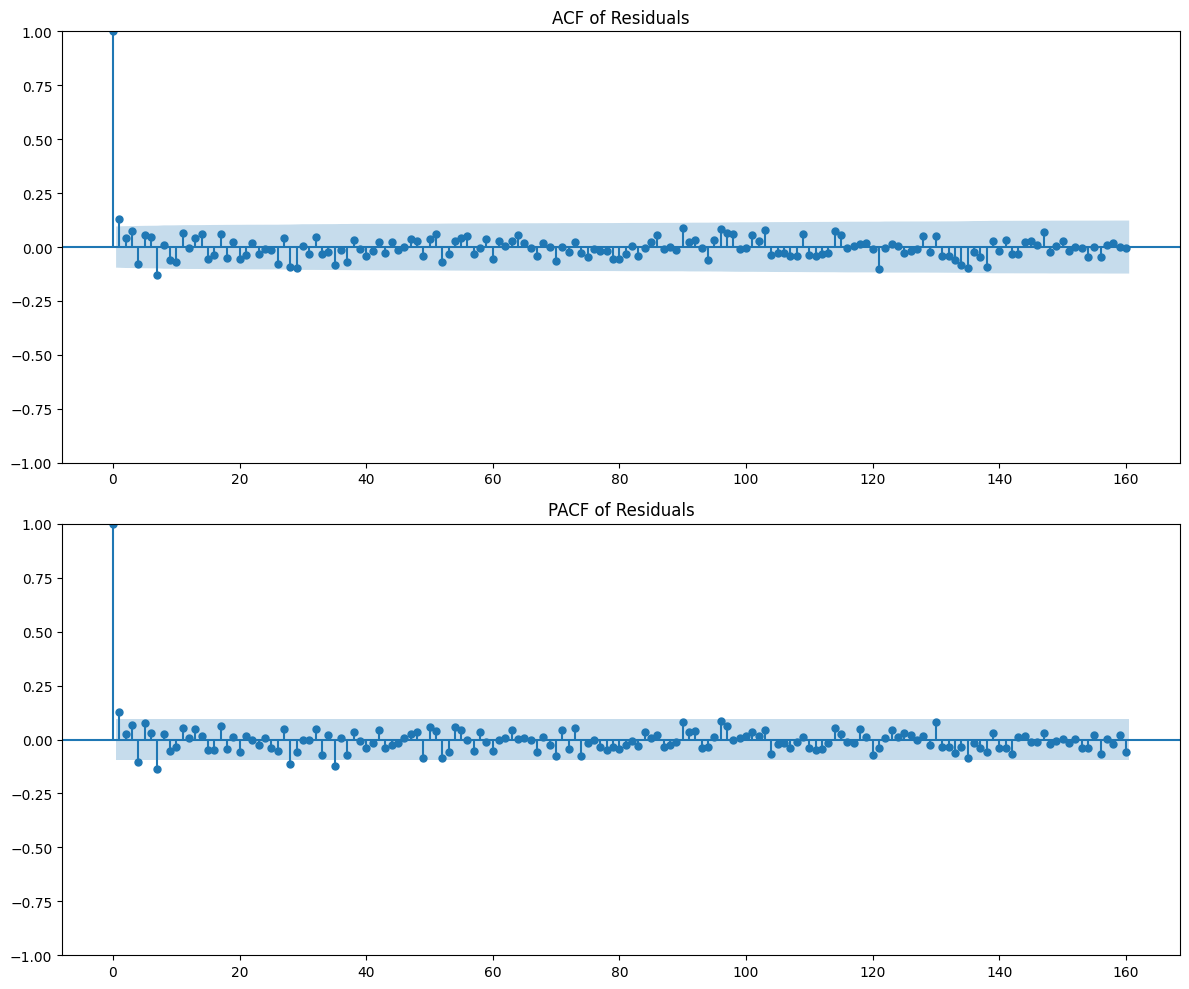

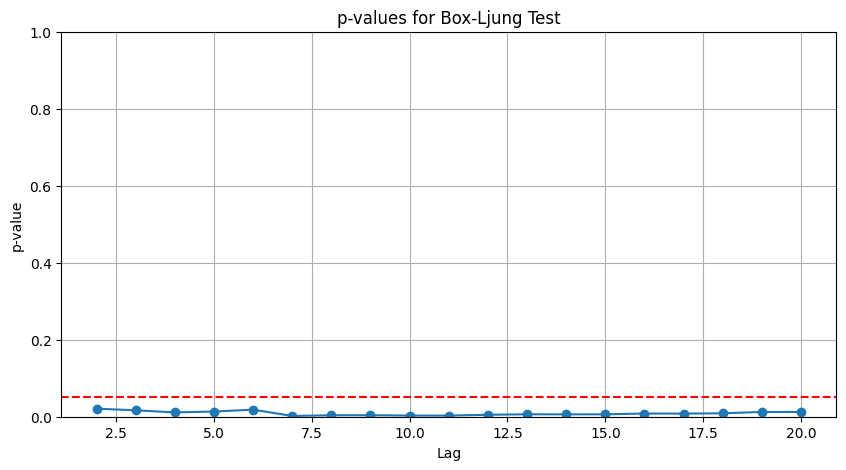

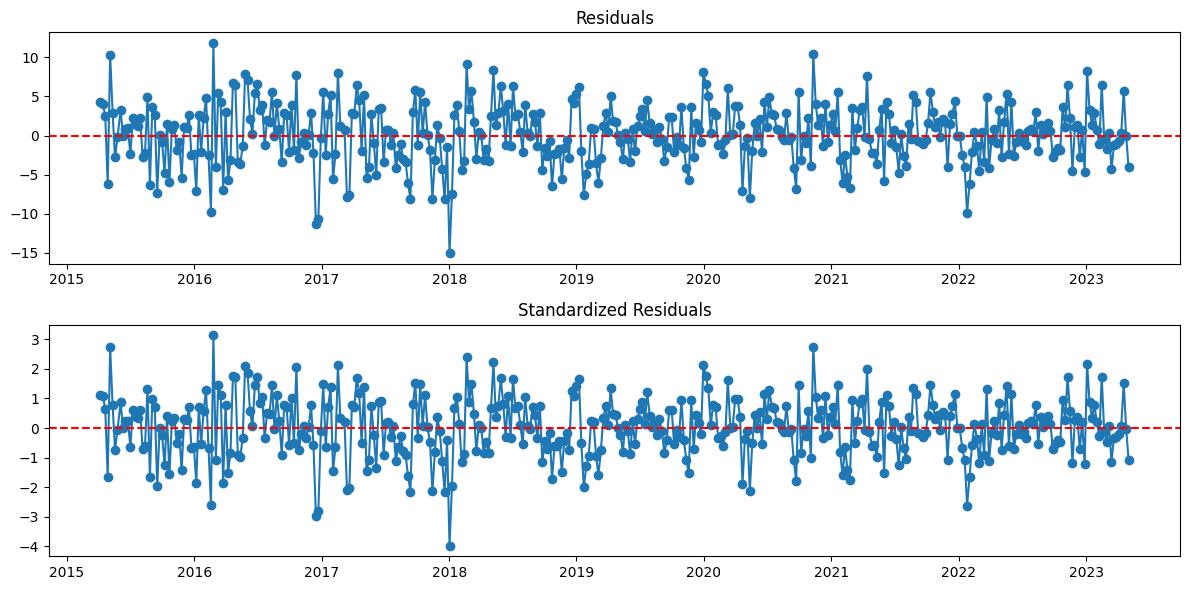

Jarque-Bera Statistic: 9.308243648049, p-value: 0.009522271801611682


In [ ]:
# 06-A-3 - Standard errors
print(np.sqrt(np.diag(fit2.cov_params())))

# 06-A-4 - Noise variance (calculate from residuals)
res2 = fit2.resid
noise_variance = np.var(res2)
print(f'Noise Variance: {noise_variance}')

# Set up graphics
plt.figure(figsize=(12, 10))

# 06-A-5 - Histogram of residuals
plt.subplot(2, 1, 1)
plt.hist(res2, bins=12, density=True, alpha=0.6, color='b')
sns.kdeplot(res2, color='red')  # Kernel density estimate
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.grid()

# 06-A-6 - Q-Q plot
plt.subplot(2, 1, 2)
sm.qqplot(res2, line='s', ax=plt.gca())
plt.title('Normal Q-Q Plot')
plt.grid()

plt.tight_layout()
plt.show()

# 06-A-7 - ACF and PACF plots for residuals
plt.figure(figsize=(12, 10))
plt.subplot(2, 1, 1)
sm.graphics.tsa.plot_acf(res2, lags=160, ax=plt.gca(), title='ACF of Residuals')
plt.subplot(2, 1, 2)
sm.graphics.tsa.plot_pacf(res2, lags=160, ax=plt.gca(), title='PACF of Residuals')
plt.tight_layout()
plt.show()

# 06-A-8 - Box-Ljung test
p_values = []
for lag in range(2, 21):
    try:
        lb_test = acorr_ljungbox(res2, lags=[lag], return_df=True)
        p_values.append(lb_test.iloc[0]['lb_pvalue'])  # Extract p-value
    except Exception as e:
        print(f'Error for lag {lag}: {e}')
        p_values.append(None)  # Append None for errors

# 06-A-9 - Plot p-values for Box-Ljung test
plt.figure(figsize=(10, 5))
plt.plot(range(2, 21), p_values, marker='o')
plt.axhline(y=0.05, color='r', linestyle='--')
plt.title('p-values for Box-Ljung Test')
plt.xlabel('Lag')
plt.ylabel('p-value')
plt.ylim(0, 1)
plt.grid()
plt.show()

# 06-A-10 - Plot residuals and standardized residuals
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(res2, marker='o')
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuals')

# 06-A-11 - Standardized residuals calculation
std_residuals = res2 / np.std(res2)

plt.subplot(2, 1, 2)
plt.plot(std_residuals, marker='o')
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Standardized Residuals')
plt.tight_layout()
plt.show()

# 06-A-12 - Jarque-Bera test for normality
jb_stat, jb_p = jarque_bera(res2)
print(f'Jarque-Bera Statistic: {jb_stat}, p-value: {jb_p}')

One lag out in ACF and PACF, try ARIMA(1,1,1).

**06-B - 2nd Adjustment**

In [ ]:
# 06-B-1 - Fit ARIMA model (1,1,1) with seasonal (0,1,1) and period=52
model = ARIMA(TAVG, order=(1, 1, 1), seasonal_order=(0, 1, 1, 52))
fit3 = model.fit()

# 06-B-2 - Parameter estimates
print(fit3.params)

c:\Users\horac\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\horac\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\horac\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ar.L1       0.232360
ma.L1      -0.976967
ma.S.L52   -0.998433
sigma2      9.190688
dtype: float64


[5.22315535e-02 1.47488843e-02 1.07263168e+01 9.83021916e+01]
Noise Variance: 13.581979360961935


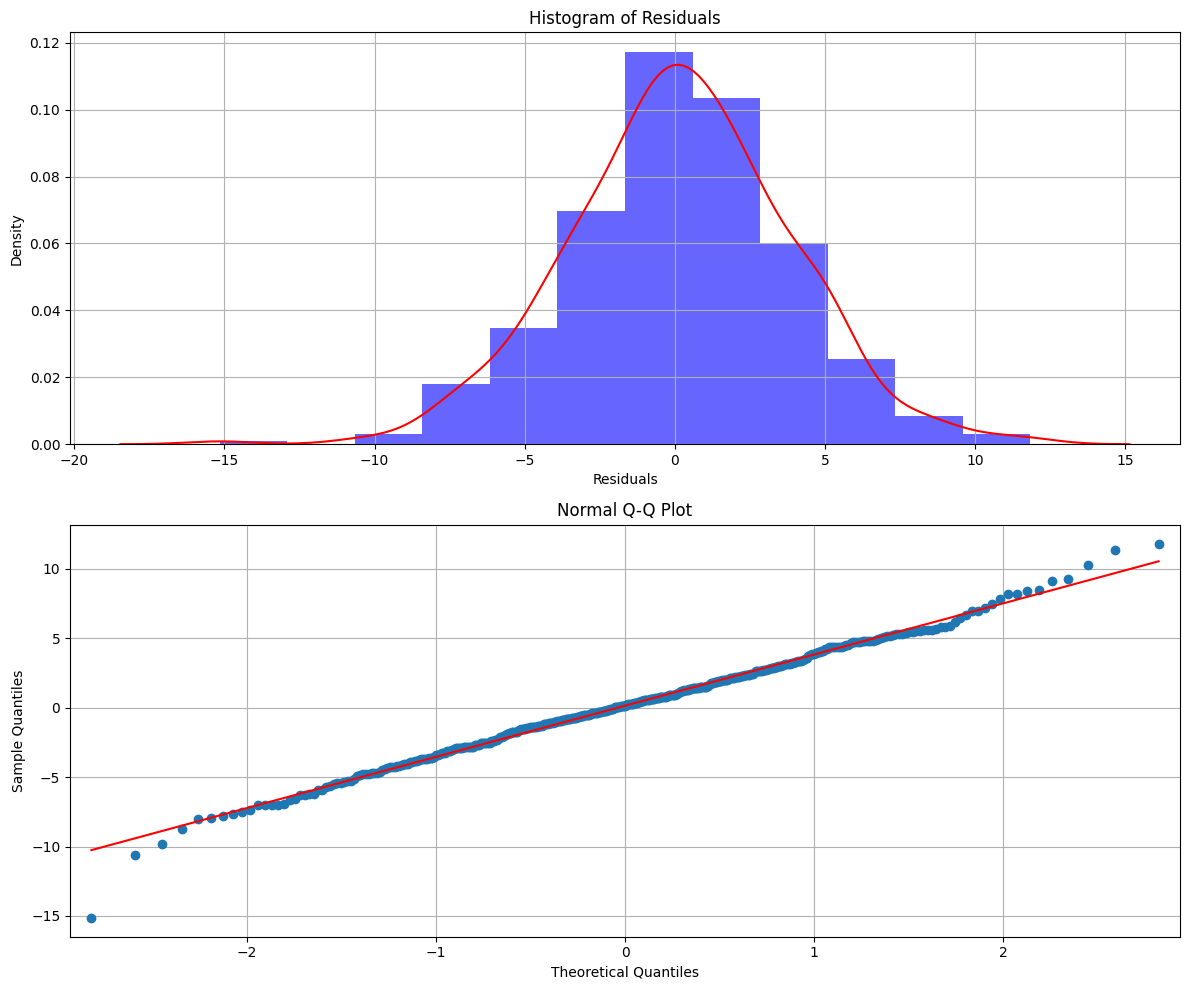

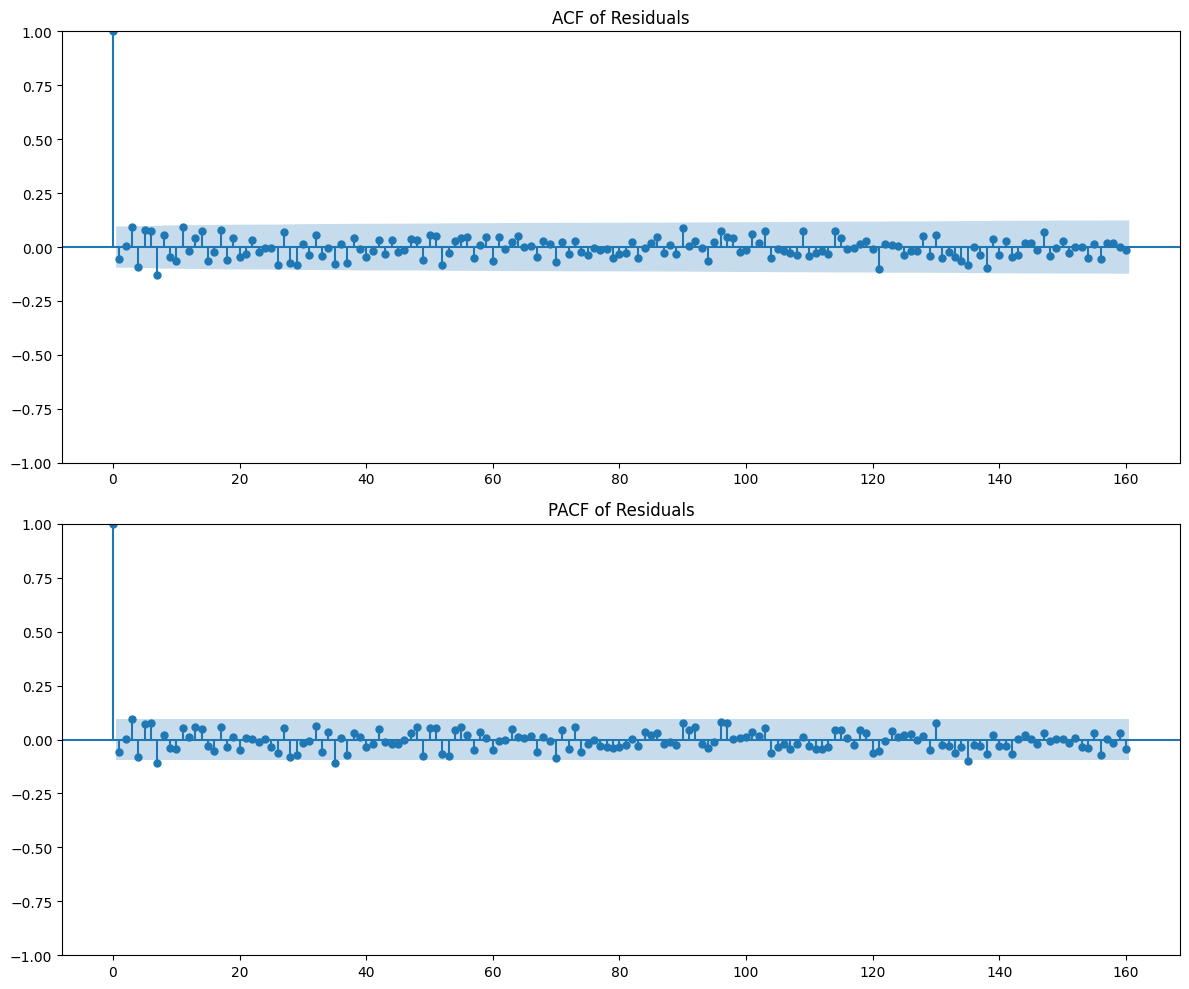

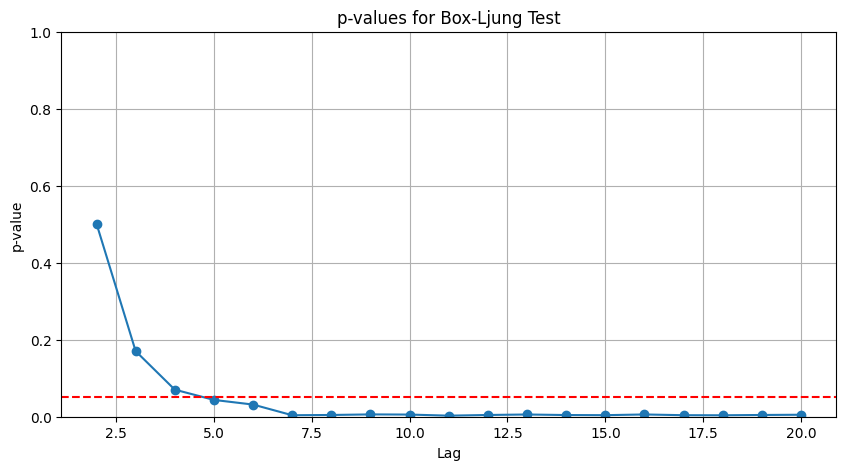

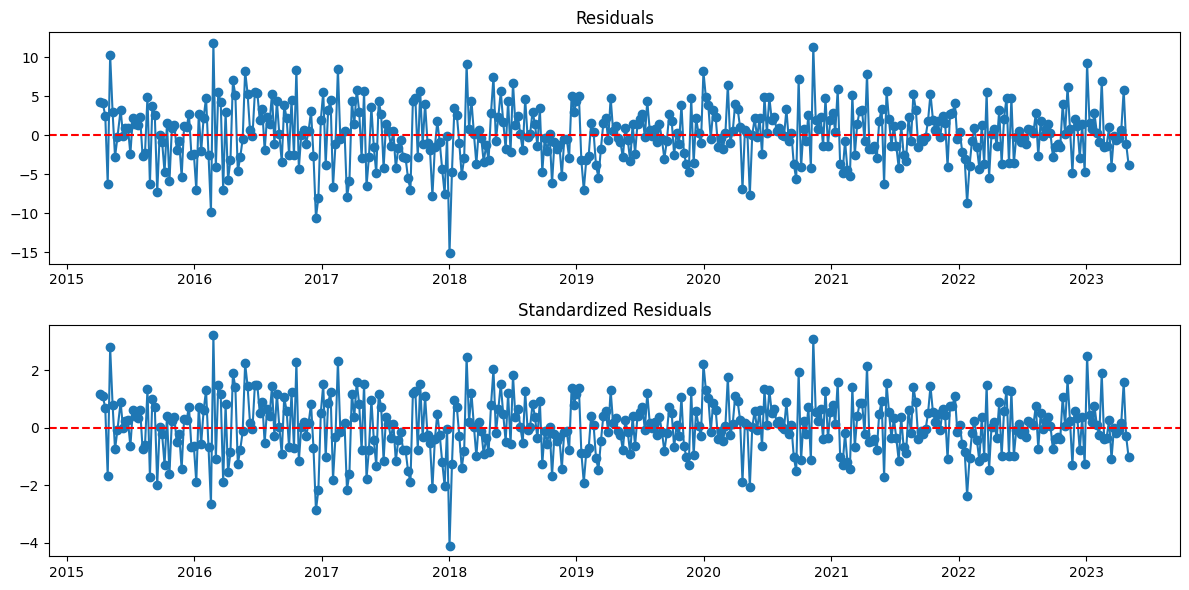

Jarque-Bera Statistic: 8.130298684855784, p-value: 0.017160426302499584


In [ ]:
# 06-B-3 - Standard errors
print(np.sqrt(np.diag(fit3.cov_params())))

# 06-B-4 - Noise variance (calculate from residuals)
res3 = fit3.resid
noise_variance = np.var(res3)
print(f'Noise Variance: {noise_variance}')

# Set up graphics
plt.figure(figsize=(12, 10))

# 06-B-5 - Histogram of residuals
plt.subplot(2, 1, 1)
plt.hist(res3, bins=12, density=True, alpha=0.6, color='b')
sns.kdeplot(res3, color='red')  # Kernel density estimate
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.grid()

# 06-B-6 - Q-Q plot
plt.subplot(2, 1, 2)
sm.qqplot(res3, line='s', ax=plt.gca())
plt.title('Normal Q-Q Plot')
plt.grid()

plt.tight_layout()
plt.show()

# 06-B-7 - ACF and PACF plots for residuals
plt.figure(figsize=(12, 10))
plt.subplot(2, 1, 1)
sm.graphics.tsa.plot_acf(res3, lags=160, ax=plt.gca(), title='ACF of Residuals')
plt.subplot(2, 1, 2)
sm.graphics.tsa.plot_pacf(res3, lags=160, ax=plt.gca(), title='PACF of Residuals')
plt.tight_layout()
plt.show()

# 06-B-8 - Box-Ljung test
p_values = []
for lag in range(2, 21):
    try:
        lb_test = acorr_ljungbox(res3, lags=[lag], return_df=True)
        p_values.append(lb_test.iloc[0]['lb_pvalue'])  # Extract p-value
    except Exception as e:
        print(f'Error for lag {lag}: {e}')
        p_values.append(None)  # Append None for errors

# 06-B-9 - Plot p-values for Box-Ljung test
plt.figure(figsize=(10, 5))
plt.plot(range(2, 21), p_values, marker='o')
plt.axhline(y=0.05, color='r', linestyle='--')
plt.title('p-values for Box-Ljung Test')
plt.xlabel('Lag')
plt.ylabel('p-value')
plt.ylim(0, 1)
plt.grid()
plt.show()

# 06-B-10 - Plot residuals and standardized residuals
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(res3, marker='o')
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuals')

# 06-B-11 - Standardized residuals calculation
std_residuals = res3 / np.std(res3)

plt.subplot(2, 1, 2)
plt.plot(std_residuals, marker='o')
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Standardized Residuals')
plt.tight_layout()
plt.show()

# 06-B-12 - Jarque-Bera test for normality
jb_stat, jb_p = jarque_bera(res3)
print(f'Jarque-Bera Statistic: {jb_stat}, p-value: {jb_p}')

**06-C - Akaike information criterion (AIC) and Bayesian information criterion (BIC) Comparison**

In [ ]:
# 06-C-1 - Function for calculating AIC and BIC
def diag1(xdata, fitit):
    # Get the number of observations
    n = len(xdata)

    # Extract the number of parameters from the fitted model
    k = len(fitit.params)

    # Log-likelihood of the fitted model
    loglik = fitit.llf

    # Calculate AIC
    AIC = -2 * loglik + 2 * k

    # Calculate BIC
    BIC = -2 * loglik + k * np.log(n)

    # Calculate AICc
    AICc = AIC + 2 * (1 + k) * (k + 2) / (n - k - 2)

    return {
        'AIC': AIC,
        'AICc': AICc,
        'BIC': BIC
    }



# 06-C-2 - Compute diagnostics for each model
print(diag1(TAVG, fit1))
print(diag1(TAVG, fit2))
print(diag1(TAVG, fit3))
# fit3 gives the lowest AIC, AICc and BIC, therefore it is the best fit.

{'AIC': 2142.6374899140396, 'AICc': 2142.695043870874, 'BIC': 2150.7227555814043}
{'AIC': 1996.5668320795216, 'AICc': 1996.6629859256755, 'BIC': 2008.6947305805688}
{'AIC': 1979.8408855483754, 'AICc': 1979.9854638616284, 'BIC': 1996.0114168831049}


**06-D - Final Fitting**

In [ ]:
# 06-D-1 - Fit ARIMA model (1,1,1) with seasonal (0,1,1) and period=52
model = ARIMA(TAVG, order=(1, 1, 1), seasonal_order=(0, 1, 1, 52))
fit4 = model.fit()

# 06-D-2 - Parameter estimates
print("Parameter Estimates:")
print(fit4.params)

c:\Users\horac\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\horac\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\horac\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Parameter Estimates:
ar.L1       0.232360
ma.L1      -0.976967
ma.S.L52   -0.998433
sigma2      9.190688
dtype: float64


Standard Errors:
ar.L1        0.052232
ma.L1        0.014749
ma.S.L52    10.726317
sigma2      98.302192
dtype: float64
Noise Variance (Residual Variance): 13.581979360961935


C:\Users\horac\AppData\Local\Temp\ipykernel_19368\4288430699.py:14: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  residuals_adjusted[io_indices] = np.nan  # Replace identified IOs with NaNs or adjust as needed


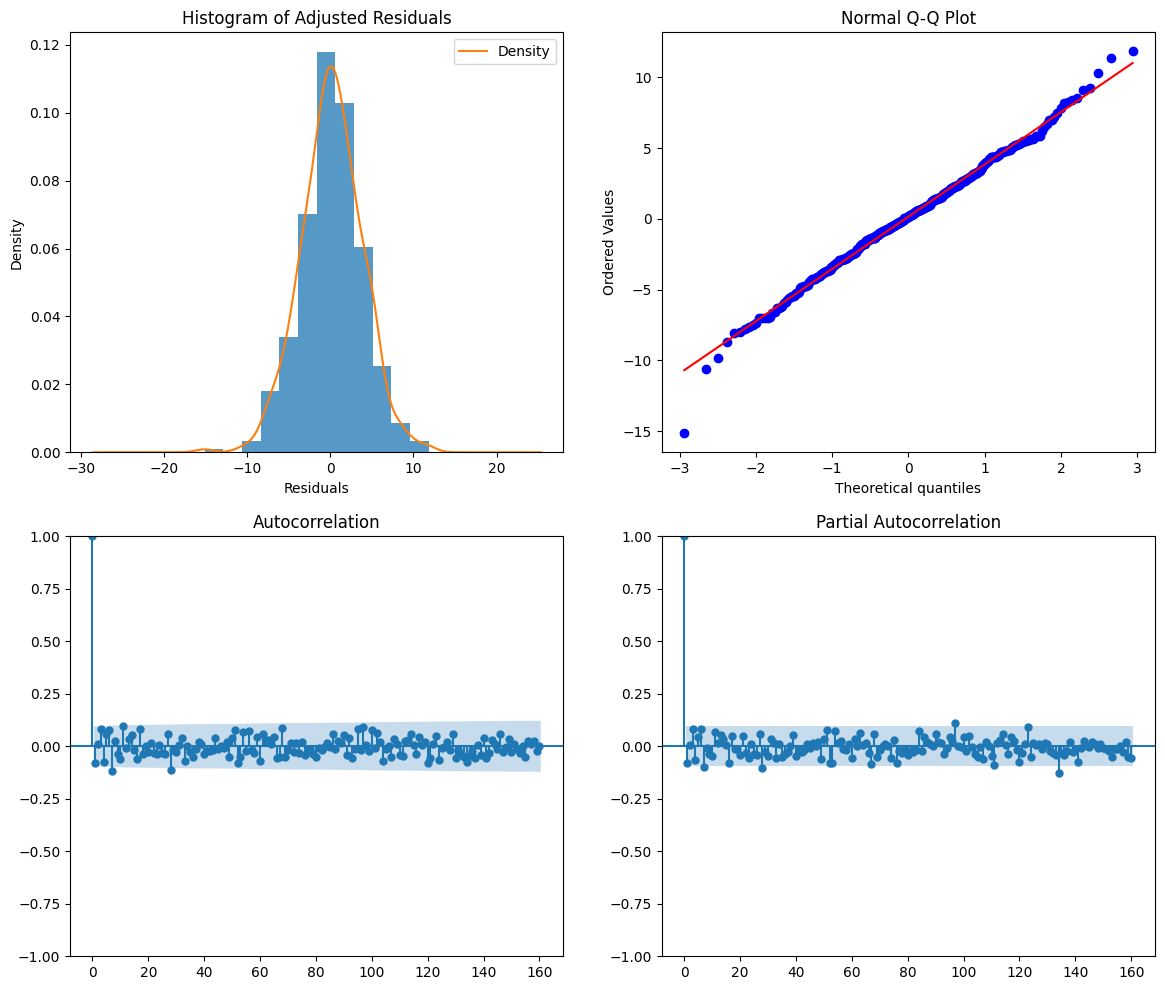

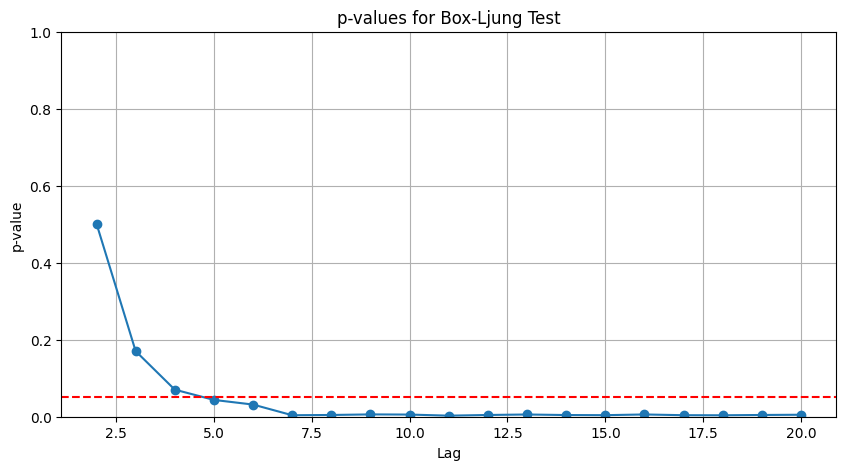

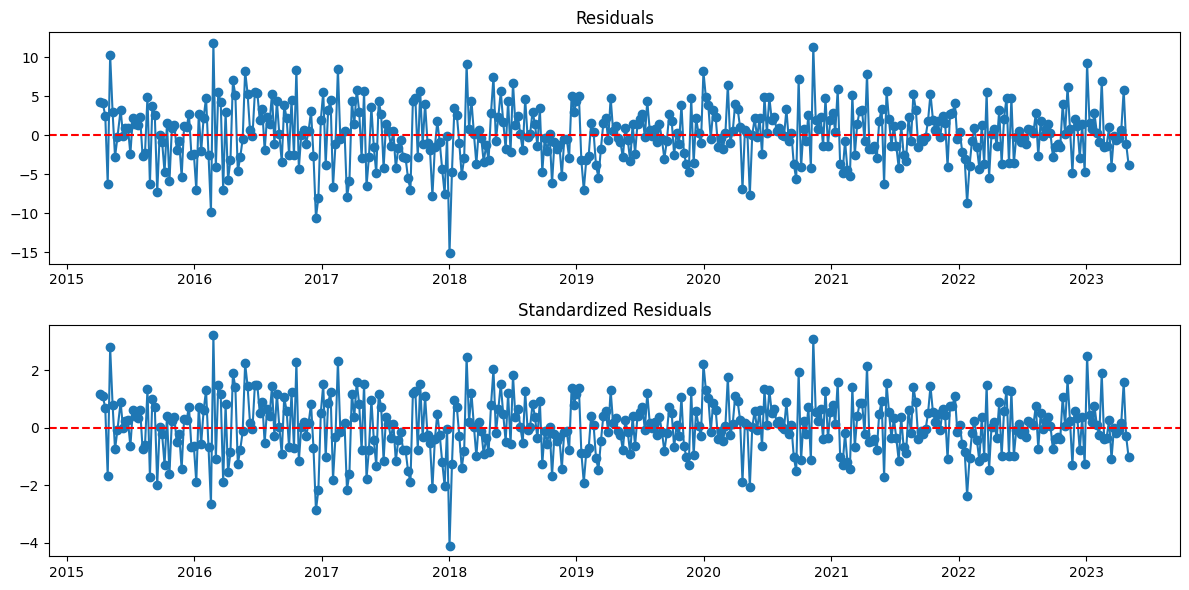

Jarque-Bera Statistic: 8.130298684855784, p-value: 0.017160426302499584
Innovational Outliers adjusted at indices: [143, 292]


In [ ]:
# 06-D-3 - Standard errors
print("Standard Errors:")
print(fit4.bse)

# 06-D-4 - Compute noise variance (residual variance)
residual_variance = np.var(fit4.resid)
print("Noise Variance (Residual Variance):", residual_variance)
io_indices = [143, 292]

# 06-D-5 - Adjust residuals for identified IOs
residuals_adjusted = fit4.resid.copy()
residuals_adjusted[io_indices] = np.nan  # Replace identified IOs with NaNs or adjust as needed

# 06-D-6 - Plotting and diagnostics
fig, axs = plt.subplots(2, 2, figsize=(14, 12))

# 06-D-7 - Histogram
axs[0, 0].hist(residuals_adjusted.dropna(), bins=12, density=True, alpha=0.75)
axs[0, 0].set_title('Histogram of Adjusted Residuals')
axs[0, 0].set_xlabel('Residuals')
axs[0, 0].set_ylabel('Density')

# 06-D-8 - Density plot
pd.Series(residuals_adjusted.dropna()).plot(kind='density', ax=axs[0, 0])
axs[0, 0].legend(["Density"], loc="best")

# 06-D-9 - Q-Q plot
probplot(residuals_adjusted.dropna(), plot=axs[0, 1])
axs[0, 1].set_title('Normal Q-Q Plot')

# 06-D-10 - ACF and PACF plots
plot_acf(residuals_adjusted.dropna(), lags=160, ax=axs[1, 0])
plot_pacf(residuals_adjusted.dropna(), lags=160, ax=axs[1, 1])

p_values = []
for lag in range(2, 21):
    try:
        lb_test = acorr_ljungbox(res3, lags=[lag], return_df=True)
        p_values.append(lb_test.iloc[0]['lb_pvalue'])  # Extract p-value
    except Exception as e:
        print(f'Error for lag {lag}: {e}')
        p_values.append(None)  # Append None for errors

# 06-D-11 - Plot p-values for Box-Ljung test
plt.figure(figsize=(10, 5))
plt.plot(range(2, 21), p_values, marker='o')
plt.axhline(y=0.05, color='r', linestyle='--')
plt.title('p-values for Box-Ljung Test')
plt.xlabel('Lag')
plt.ylabel('p-value')
plt.ylim(0, 1)
plt.grid()
plt.show()

# 06-D-12 - Plot residuals and standardized residuals
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(res3, marker='o')
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuals')

# 06-D-13 - Standardized residuals calculation
std_residuals = res3 / np.std(res3)

plt.subplot(2, 1, 2)
plt.plot(std_residuals, marker='o')
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Standardized Residuals')
plt.tight_layout()
plt.show()

# 06-D-14 - Jarque-Bera test for normality
jb_stat, jb_p = jarque_bera(res3)
print(f'Jarque-Bera Statistic: {jb_stat}, p-value: {jb_p}')

print("Innovational Outliers adjusted at indices:", io_indices)

**07 - Auto ARIMA - Development of ARIMA Model**

In [ ]:
# 07-1 - Define model parameters and call the auto ARIMA function
auto_model = pm.auto_arima(TAVG , error_action = 'ignore' , trace = True , suppress_warnings = True ,
                           maxiter = 3 ,
                           seasonal = True , m = 52 ,
                           d = 1  ,D = 1)

# 07-2 - Parameter estimates
print("Parameter Estimates:")
print(auto_model.params)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[52]             : AIC=inf, Time=12.18 sec
 ARIMA(0,1,0)(0,1,0)[52]             : AIC=2282.671, Time=0.55 sec
 ARIMA(1,1,0)(1,1,0)[52]             : AIC=2135.064, Time=4.04 sec
 ARIMA(0,1,1)(0,1,1)[52]             : AIC=inf, Time=7.55 sec
 ARIMA(1,1,0)(0,1,0)[52]             : AIC=2226.305, Time=0.25 sec
 ARIMA(1,1,0)(2,1,0)[52]             : AIC=inf, Time=8.94 sec
 ARIMA(1,1,0)(1,1,1)[52]             : AIC=inf, Time=7.83 sec
 ARIMA(1,1,0)(0,1,1)[52]             : AIC=inf, Time=7.49 sec
 ARIMA(1,1,0)(2,1,1)[52]             : AIC=2090.108, Time=16.08 sec
 ARIMA(1,1,0)(2,1,2)[52]             : AIC=inf, Time=18.19 sec
 ARIMA(1,1,0)(1,1,2)[52]             : AIC=inf, Time=11.71 sec
 ARIMA(0,1,0)(2,1,1)[52]             : AIC=2157.293, Time=12.40 sec
 ARIMA(2,1,0)(2,1,1)[52]             : AIC=2062.080, Time=18.87 sec
 ARIMA(2,1,0)(1,1,1)[52]             : AIC=inf, Time=12.42 sec
 ARIMA(2,1,0)(2,1,0)[52]             : AIC=2075.698,

In [ ]:
# 07-3 - Compute the AIC, AICc and BIC for the auto model
# Calculate AIC
AIC = auto_model.aic()

# Calculate BIC
BIC = auto_model.bic()

# Calculate AICc
AICc = auto_model.aicc()


print('AIC: ' , AIC)
print('AICc: ' , AICc)
print('BIC: ' , BIC)


AIC:  2043.0796003780065
AICc:  2043.517556582386
BIC:  2078.2523468215268


**08 - Validation of Model Performance**
<br>
<br>
**08-1 - Preparation Work for Presenting the Prediction Results**

In [ ]:
# 08-1-1 - Prepare the dataframe object for showcasing the prediction results
TAVG_full = pd.DataFrame(pd.concat([TAVG , TAVG_test] , axis = 0))
TAVG_full = TAVG_full.rename(columns = {0 : 'Average Temp - Weekly'})

In [ ]:
# 08-1-2 - Function for calculating the errors (MPE, MSE, MAE and MAPE) from the prediction results
def Error_Calculation(xdata, preddata):
    n = len(preddata)
    m = len(xdata)
    e = np.array(xdata) - np.array(preddata)  # Calculate the error between testing data and prediction

    MSE = np.mean(e**2)
    MPE = np.mean(e / np.array(xdata))
    MAE = np.mean(np.abs(e))
    MAPE = np.mean(np.abs(e / np.array(xdata)))
    return {"MPE": MPE, "MSE": MSE, "MAE": MAE, "MAPE": MAPE}

**08-2 - Prediction Results - Manual ARIMA Model**

Prediction Results from Manual ARIMA Model:

Mean Percentage Error (MPE) = 3.0790492933304434
Mean Square Error (MSE) = 8.935407695848987
Mean Absolute Error (MAE) = 2.4293579983413847
Mean Absolute Percentage Error (MAPE) = 3.2976258175532314 



c:\Users\horac\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\horac\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


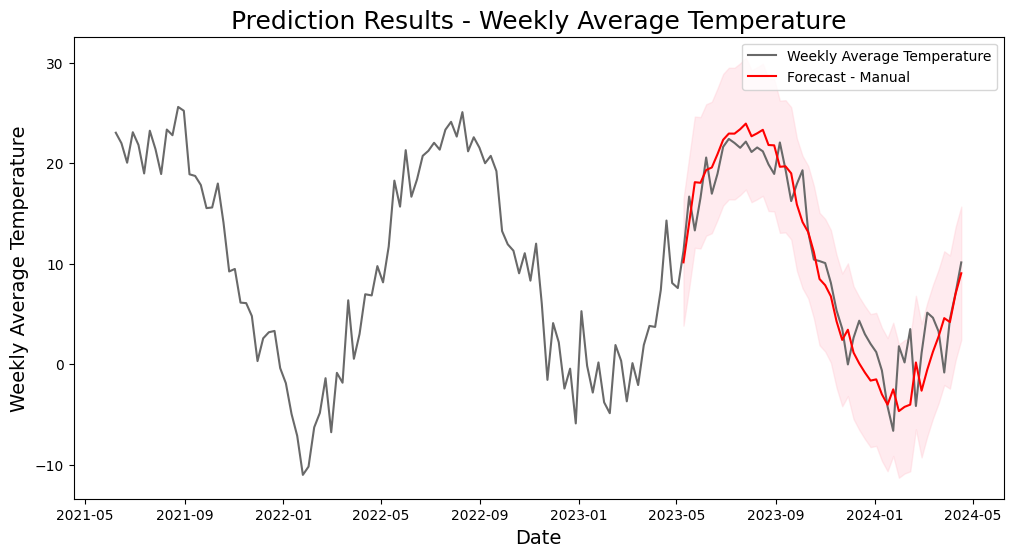

In [ ]:
# 08-2-1 - Prediction - Manual ARIMA Model
forecast_manual = fit4.get_forecast(testing_range)

# Get the confidence intervals
conf_int = forecast_manual.conf_int(alpha=0.05)

# 08-2-2 - Calculate and present the prediction error
errors_manual = Error_Calculation(TAVG_test, forecast_manual.predicted_mean)

print("Prediction Results from Manual ARIMA Model:\n")
print("Mean Percentage Error (MPE) =", errors_manual['MPE'])
print("Mean Square Error (MSE) =", errors_manual['MSE'])
print("Mean Absolute Error (MAE) =", errors_manual['MAE'])
print("Mean Absolute Percentage Error (MAPE) =", errors_manual['MAPE'], "\n")

# 08-2-3 - Organize the prediction results into the full dataframe for presentation
TAVG_full['Forecast - Manual'] = [None] * len(TAVG) + list(forecast_manual.predicted_mean)
TAVG_full['Lower 95% - Manual'] = [None] * len(TAVG) + list(conf_int.iloc[:, 0])
TAVG_full['Upper 95% - Manual'] = [None] * len(TAVG) + list(conf_int.iloc[:, 1])

# 08-2-4 - Extract the last section of the time series for display
extraction_range = testing_range + 100
trimmed_TAVG = TAVG_full.tail(extraction_range)

# 08-2-5 - Present the prediction results onto a graph
plt.figure(figsize=(12, 6))

line1, = plt.plot(trimmed_TAVG.index, trimmed_TAVG['Average Temp - Weekly'], 'dimgrey', label='Weekly Average Temperature')
line2, = plt.plot(trimmed_TAVG.index, trimmed_TAVG['Forecast - Manual'], 'red', label='Forecast - Manual')
plt.fill_between(trimmed_TAVG.index, trimmed_TAVG['Lower 95% - Manual'], trimmed_TAVG['Upper 95% - Manual'], color='pink', alpha=0.3)

plt.title('Prediction Results - Weekly Average Temperature', fontsize=18, loc='center')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Weekly Average Temperature', fontsize=14)
plt.legend(handles=[line1, line2])

plt.show()

**08-3 - Prediction Results - Auto ARIMA Model**

Prediction Results from Auto ARIMA Model:

Mean Percentage Error (MPE) = 3.4026038415245567
Mean Square Error (MSE) = 10.029432966690779
Mean Absolute Error (MAE) = 2.5352970011550453
Mean Absolute Percentage Error (MAPE) = 3.595931879833125 



c:\Users\horac\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


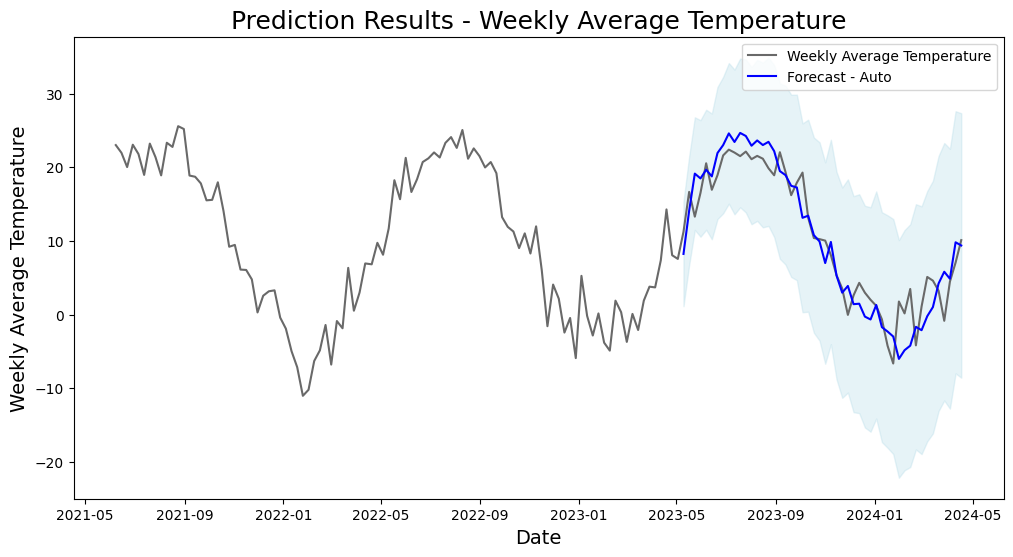

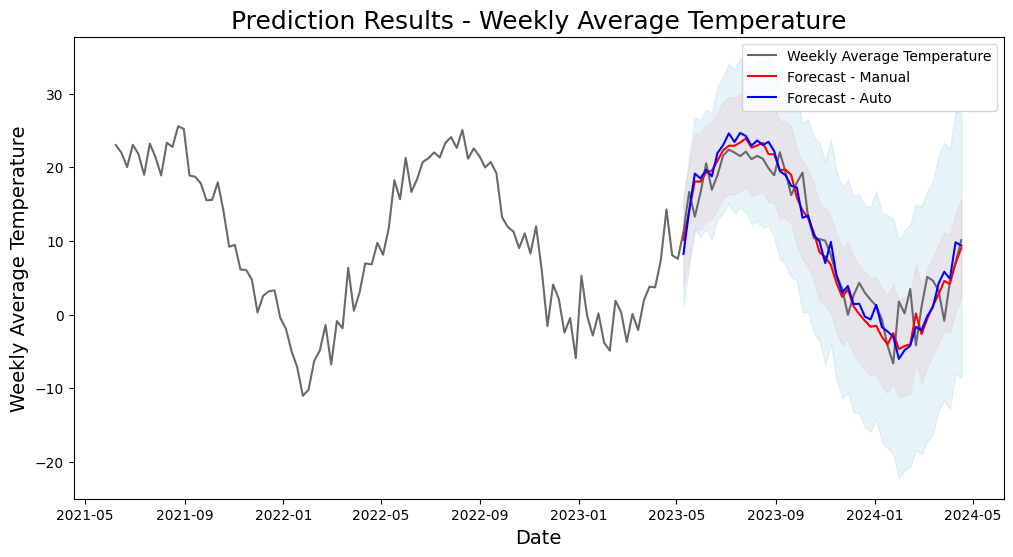

In [ ]:
# 08-3-1 - Prediction - Auto ARIMA Model
forecast_auto , conf_int_auto = auto_model.predict(testing_range , return_conf_int = True , alpha = 0.05)

# 08-3-2 - Calculate and present the prediction error
errors_auto = Error_Calculation(TAVG_test, forecast_auto)

print("Prediction Results from Auto ARIMA Model:\n")
print("Mean Percentage Error (MPE) =", errors_auto['MPE'])
print("Mean Square Error (MSE) =", errors_auto['MSE'])
print("Mean Absolute Error (MAE) =", errors_auto['MAE'])
print("Mean Absolute Percentage Error (MAPE) =", errors_auto['MAPE'], "\n")

# 08-3-3 - Organize the prediction results into the full dataframe for presentation
TAVG_full['Forecast - Auto'] = [None] * len(TAVG) + list(forecast_auto)
TAVG_full['Lower 95% - Auto'] = [None] * len(TAVG) + list(conf_int_auto[:, 0])
TAVG_full['Upper 95% - Auto'] = [None] * len(TAVG) + list(conf_int_auto[:, 1])

# 08-3-4 - Extract the last section of the time series for display
trimmed_TAVG = TAVG_full.tail(extraction_range)

# 08-3-5 - Present the prediction results onto a graph
plt.figure(figsize=(12, 6))

line1, = plt.plot(trimmed_TAVG.index, trimmed_TAVG['Average Temp - Weekly'], 'dimgrey', label='Weekly Average Temperature')
line2, = plt.plot(trimmed_TAVG.index, trimmed_TAVG['Forecast - Auto'], 'blue', label='Forecast - Auto')

# Adding prediction intervals for Auto ARIMA
plt.fill_between(trimmed_TAVG.index, trimmed_TAVG['Lower 95% - Auto'], trimmed_TAVG['Upper 95% - Auto'], color='lightblue', alpha=0.3)

plt.title('Prediction Results - Weekly Average Temperature', fontsize=18, loc='center')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Weekly Average Temperature', fontsize=14)
plt.legend(handles=[line1, line2])

plt.show()


# 08-3-6 - Present the combined prediction results from the manual and auto ARIMA model onto a graph
plt.figure(figsize=(12, 6))

line1, = plt.plot(trimmed_TAVG.index, trimmed_TAVG['Average Temp - Weekly'], 'dimgrey', label='Weekly Average Temperature')
line2, = plt.plot(trimmed_TAVG.index, trimmed_TAVG['Forecast - Manual'], 'red', label='Forecast - Manual')
line3, = plt.plot(trimmed_TAVG.index, trimmed_TAVG['Forecast - Auto'], 'blue', label='Forecast - Auto')

# Adding prediction intervals for Manual ARIMA
plt.fill_between(trimmed_TAVG.index, trimmed_TAVG['Lower 95% - Manual'], trimmed_TAVG['Upper 95% - Manual'], color='pink', alpha=0.3)

# Adding prediction intervals for Auto ARIMA
plt.fill_between(trimmed_TAVG.index, trimmed_TAVG['Lower 95% - Auto'], trimmed_TAVG['Upper 95% - Auto'], color='lightblue', alpha=0.3)

plt.title('Prediction Results - Weekly Average Temperature', fontsize=18, loc='center')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Weekly Average Temperature', fontsize=14)
plt.legend(handles=[line1, line2, line3])

plt.show()